# Needs & Limits Framework - Overview

In [1]:
import NeedsLimitsFramework as NLF

import seaborn as sns
import agentpy as ap

In [2]:
class Individual(NLF.Individual):
    
    def setup(self):
        super().setup()
        dims = range(self.p.dims)
        rand = lambda: self.model.random.random()
        
        # Prepare random dimensions
        d_keys = [f'd{i}' for i in dims]
        r_keys = [f'r{i}' for i in dims]
        r_defs = [0 for i in dims]
        a_keys = [f'a{i}' for i in dims]
        a_impacts = {key: [rand() for i in dims]
            for key in d_keys + r_keys + self.e_keys}
        
        # Add time (given per round, needed for every activity)
        a_impacts['time'] = [-rand() for i in dims]
        r_keys.append('time')
        r_defs.append(1)
        
        # Initiate dimensions
        self.add_domains(keys=d_keys, sub=self.p.sub)
        self.add_resources(keys=r_keys, defs=r_defs)
        self.add_activities(keys=a_keys, impacts=a_impacts)


class Model(NLF.Model):
    
    def setup(self):
        super().setup()
        self.agents = ap.AgentList(self, self.p.agents, Individual)
        
        # Add environmental factors
        self.e_keys = [f'e{i}' for i in range(self.p.dims)]
        self.add_efactors(keys=self.e_keys)
        
    def step(self):
        # Start of round
        self.update_e_flows()
        self.agents.update_stocks_and_flows()
        
        # Adaption phase
        self.agents.update_perceptions()
        
        # Decision phase
        self.agents.decide_activities()
        
        # Action phase
        self.agents.perform_activities()
        
        # End of round
        self.update_e_stocks()
        
        # Documentation
        self.agents.record('qol')
        self.agents.record_activities(ints=True, impacts=False)
        self.agents.record_domains(fuls=True, grts=False)
        
        # Stop simulation after first round
        self.stop()

In [3]:
parameters = {
    'agents': 100,
    'dims': 5,
    'sub': 0.1
}
model = Model(parameters)
results = model.run()

Completed: 1 steps
Run time: 0:00:04.084038
Simulation finished


In [4]:
df = results.variables.Individual
df.head()

,,qol,a_int_a0,a_int_a1,a_int_a2,a_int_a3,a_int_a4,d_ful_d0,d_ful_d1,d_ful_d2,d_ful_d3,d_ful_d4
obj_id,t,,,,,,,,,,,
1,1,0.718523,0.000000,1.090530,0.000000,1.613757,0.000000,0.816897,0.493178,0.804937,0.659834,0.885218
2,1,0.885684,0.000000,1.532090,0.000000,0.000000,2.879821,0.961123,0.942185,0.933879,0.740020,0.868859
3,1,0.999697,25.094530,0.000000,11.781496,0.000000,0.000000,1.000000,1.000000,1.000000,0.998738,0.999749
4,1,0.581083,0.237924,0.000000,2.433020,0.000000,0.000000,0.746933,0.687790,0.302957,0.593323,0.698261
5,1,0.999999,28.193843,2.552666,0.302743,0.000120,0.000000,1.000000,0.999993,1.000000,1.000000,1.000000


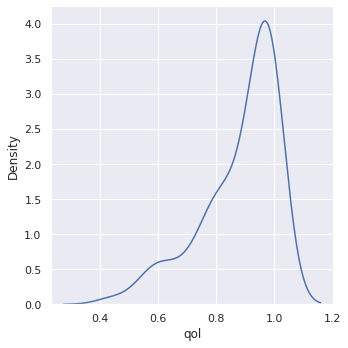

In [5]:
sns.displot(data=df, x='qol', kind='kde');